In [130]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from dython.nominal import associations
import seaborn as sns
import pypyodbc as odbc
import squarify
import pyodbc
import glob
import os
from sklearn.linear_model import LinearRegression #mô hình hồi quy tuyến tính
import statistics as sta
import math
import requests
from io import StringIO
print('Completed import lib')

Completed import lib


In [131]:
def remove_outliers(data, x):
    q25 = data[x].quantile(0.25)
    q75 = data[x].quantile(0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower = q25 - cut_off
    upper = q75 + cut_off
    data = data[(data[x] < upper) & (data[x] > lower)]
    print(f"Outliers of {x} are removed\n")
    return data

In [132]:
df = pd.read_csv('loans_full_schema.csv')
df

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,owner,10.0,TX,RENT,108000.0,Source Verified,22.28,NaN,NaN,NaN,...,A4,Jan-2018,Current,whole,Cash,21586.34,2969.80,2413.66,556.14,0.0
9996,director,8.0,PA,MORTGAGE,121000.0,Verified,32.38,NaN,NaN,NaN,...,D3,Feb-2018,Current,whole,Cash,9147.44,1456.31,852.56,603.75,0.0
9997,toolmaker,10.0,CT,MORTGAGE,67000.0,Verified,45.26,107000.0,Source Verified,29.57,...,E2,Feb-2018,Current,fractional,Cash,27617.65,4620.80,2382.35,2238.45,0.0
9998,manager,1.0,WI,MORTGAGE,80000.0,Source Verified,11.99,NaN,NaN,NaN,...,A1,Feb-2018,Current,whole,Cash,21518.12,2873.31,2481.88,391.43,0.0


In [133]:
df['state'] = df['state'].replace(['KY', 'NM', 'AK', 'UT', 'DC', 'FL', 'OK', 'WA', 'NH', 
                                   'AL', 'TX', 'HI', 'AZ', 'DE', 'ID', 'MN', 'CO', 'NC', 
                                   'WV', 'KS', 'MO', 'WI', 'MI', 'CA', 'AR', 'NJ', 'MS', 
                                   'ND', 'MA', 'TN', 'VA', 'SC', 'NE', 'IN', 'MD', 'WY', 
                                   'VT', 'RI', 'PA', 'LA', 'NY', 'SD', 'ME', 'GA', 'CT', 
                                   'NV', 'MT', 'IL', 'OH', 'OR'],[1,2,3,4,5,6,7,8,9,10,11,
                                    12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,
                                    30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50])

df['emp_title'].fillna(value='Other', inplace=True)
df['verification_income_joint'].fillna(value='Other', inplace=True)
# df['emp_length'].fillna(value=df['emp_length'].mean(), inplace=True)
# df['debt_to_income'].fillna(value=df['debt_to_income'].mean(), inplace=True)

df = df.fillna(df.mean())

C:\Users\dk201\AppData\Local\Temp/ipykernel_11768/1052329668.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


In [134]:
df.describe()

,emp_length,state,annual_income,debt_to_income,annual_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,...,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
count,10000.000000,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.00000,10000.000000,10000.00000,10000.00000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.930306,26.146300,7.922215e+04,19.308192,1.279146e+05,19.979304,0.21600,36.760709,2001.29000,1.95820,...,0.123800,16361.922500,43.272000,12.427524,476.205323,14458.916610,2494.234773,1894.448466,599.666781,0.119516
std,3.549197,13.807946,6.473429e+04,14.986833,2.712304e+04,3.113514,0.68366,14.255166,7.79551,2.38013,...,0.337172,10301.956759,11.029877,5.001105,294.851627,9964.561865,3958.230365,3884.407175,517.328062,1.813468
min,0.000000,1.000000,0.000000e+00,0.000000,1.920000e+04,0.320000,0.00000,1.000000,1963.00000,0.00000,...,0.000000,1000.000000,36.000000,5.310000,30.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,13.000000,4.500000e+04,11.067500,1.279146e+05,19.979304,0.00000,36.760709,1997.00000,0.00000,...,0.000000,8000.000000,36.000000,9.430000,256.040000,6679.065000,928.700000,587.100000,221.757500,0.000000
50%,5.930306,24.000000,6.500000e+04,17.600000,1.279146e+05,19.979304,0.00000,36.760709,2003.00000,1.00000,...,0.000000,14500.000000,36.000000,11.980000,398.420000,12379.495000,1563.300000,984.990000,446.140000,0.000000
75%,10.000000,39.000000,9.500000e+04,24.990000,1.279146e+05,19.979304,0.00000,36.760709,2006.00000,3.00000,...,0.000000,24000.000000,60.000000,15.050000,644.690000,20690.182500,2616.005000,1694.555000,825.420000,0.000000
max,10.000000,50.000000,2.300000e+06,469.090000,1.100000e+06,39.980000,13.00000,118.000000,2015.00000,29.00000,...,3.000000,40000.000000,60.000000,30.940000,1566.590000,40000.000000,41630.443684,40000.000000,4216.440000,52.980000


In [135]:
df.describe(include = 'object')

,emp_title,homeownership,verified_income,verification_income_joint,loan_purpose,application_type,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,4742,3,3,4,12,2,7,32,3,6,2,2
top,Other,MORTGAGE,Source Verified,Other,debt_consolidation,individual,B,B1,Mar-2018,Current,whole,Cash
freq,833,4789,4116,8545,5144,8505,3037,647,3617,9375,8206,9284


In [136]:
corr_price = df[df.columns[:]].corr()['interest_rate'][:]
corr_price

emp_length                         -0.028405
state                               0.009552
annual_income                      -0.099584
debt_to_income                      0.141393
annual_income_joint                -0.068583
debt_to_income_joint                0.110519
delinq_2y                           0.090456
months_since_last_delinq           -0.053720
earliest_credit_line                0.103635
inquiries_last_12m                  0.131193
total_credit_lines                 -0.044435
open_credit_lines                  -0.012773
total_credit_limit                 -0.130497
total_credit_utilized               0.031527
num_collections_last_12m            0.029901
num_historical_failed_to_pay        0.037563
months_since_90d_late              -0.033451
current_accounts_delinq             0.007184
total_collection_amount_ever        0.013532
current_installment_accounts        0.047131
accounts_opened_24m                 0.120657
months_since_last_credit_inquiry   -0.094503
num_satisf

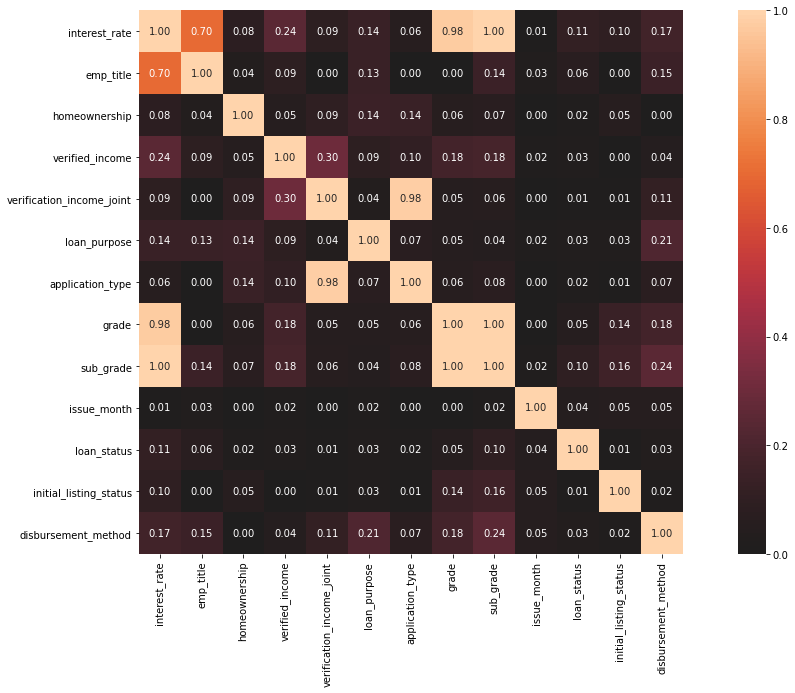

{'corr':                            interest_rate  emp_title  homeownership  \
 interest_rate                   1.000000   0.696759       0.080557   
 emp_title                       0.696759   1.000000       0.038106   
 homeownership                   0.080557   0.038106       1.000000   
 verified_income                 0.243823   0.086304       0.052994   
 verification_income_joint       0.093677   0.000000       0.094805   
 loan_purpose                    0.138838   0.133684       0.142468   
 application_type                0.061201   0.000000       0.135708   
 grade                           0.975167   0.000000       0.056599   
 sub_grade                       0.999188   0.142214       0.065262   
 issue_month                     0.011122   0.031219       0.000000   
 loan_status                     0.111421   0.063335       0.018578   
 initial_listing_status          0.100040   0.000000       0.054778   
 disbursement_method             0.168792   0.146473       0.000000  

In [137]:
associations(df[['interest_rate','emp_title','homeownership','verified_income','verification_income_joint','loan_purpose','application_type','grade','sub_grade',
                 'issue_month','loan_status','initial_listing_status','disbursement_method']],figsize=(20,10))

In [138]:
# Chon các biến có corr >= 0.1 và <= -0.1 
features = df[['emp_title','verified_income','loan_purpose','grade','sub_grade',
              'loan_status','initial_listing_status','disbursement_method','annual_income','debt_to_income','annual_income_joint','debt_to_income_joint','earliest_credit_line','inquiries_last_12m',
              'total_credit_limit','accounts_opened_24m','total_debit_limit','term','num_mort_accounts','account_never_delinq_percent','installment','interest_rate']]
features['verified_income'] = features['verified_income'].replace(['Verified','Not Verified','Source Verified'],[1,2,3])
features['loan_purpose'] = features['loan_purpose'].replace(['moving','debt_consolidation','other','credit_card',
                                                             'home_improvement','medical','house','small_business',
                                                             'car','major_purchase','vacation','renewable_energy'],[1,2,3,4,5,6,7,8,9,10,11,12])
features['grade'] = features['grade'].replace(['A','B','C','D','E','F','G'],[1,2,3,4,5,6,7])
features['sub_grade'] = features['sub_grade'].replace(['A1','A2','A3','A4','A5',
                                                       'B1','B2','B3','B4','B5',
                                                       'C1','C2','C3','C4','C5',
                                                       'D1','D2','D3','D4','D5',
                                                       'E1','E2','E3','E4','E5',
                                                       'F1','F2','F3','F4','F5',
                                                       'G1','G4'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32])
features['loan_status'] = features['loan_status'].replace(['Current','Fully Paid','In Grace Period','Late (31-120 days)','Charged Off','Late (16-30 days)'],[1,2,3,4,5,6])
features['initial_listing_status'] = features['initial_listing_status'].replace(['whole','fractional',],[1,2])
features['disbursement_method'] = features['disbursement_method'].replace(['Cash','DirectPay',],[1,2])
features['emp_title'] = features['emp_title'].replace(np.array(list(set(features['emp_title']))),np.array(range(1,4743)))
# features
features.head(6)

C:\Users\dk201\AppData\Local\Temp/ipykernel_11768/2077096130.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['verified_income'] = features['verified_income'].replace(['Verified','Not Verified','Source Verified'],[1,2,3])
C:\Users\dk201\AppData\Local\Temp/ipykernel_11768/2077096130.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['loan_purpose'] = features['loan_purpose'].replace(['moving','debt_consolidation','other','credit_card',
C:\Users\dk201\AppData\Local\Temp/ipykernel_11768/2

,emp_title,verified_income,loan_purpose,grade,sub_grade,loan_status,initial_listing_status,disbursement_method,annual_income,debt_to_income,...,earliest_credit_line,inquiries_last_12m,total_credit_limit,accounts_opened_24m,total_debit_limit,term,num_mort_accounts,account_never_delinq_percent,installment,interest_rate
0,2928,1,1,3,13,1,1,1,90000.0,18.01,...,2001,6,70795,5,11100,60,1,92.9,652.53,14.07
1,4103,2,2,3,11,1,1,1,40000.0,5.04,...,1996,1,28800,11,16500,36,0,100.0,167.54,12.61
2,711,3,3,4,16,1,2,1,40000.0,21.15,...,2006,4,24193,13,4300,36,0,93.5,71.40,17.09
3,1449,2,2,1,3,1,1,1,30000.0,10.16,...,2007,0,25400,1,19400,36,0,100.0,664.19,6.72
4,4679,1,4,3,13,1,1,1,35000.0,57.96,...,2008,7,69839,6,32700,36,0,100.0,786.87,14.07
5,2859,2,3,1,3,1,1,1,34000.0,6.46,...,1990,6,42100,2,27200,36,3,78.1,153.75,6.72


In [139]:
features.isnull().sum()

emp_title                       0
verified_income                 0
loan_purpose                    0
grade                           0
sub_grade                       0
loan_status                     0
initial_listing_status          0
disbursement_method             0
annual_income                   0
debt_to_income                  0
annual_income_joint             0
debt_to_income_joint            0
earliest_credit_line            0
inquiries_last_12m              0
total_credit_limit              0
accounts_opened_24m             0
total_debit_limit               0
term                            0
num_mort_accounts               0
account_never_delinq_percent    0
installment                     0
interest_rate                   0
dtype: int64

Outliers of annual_income are removed

Outliers of debt_to_income are removed

Outliers of annual_income_joint are removed

Outliers of debt_to_income_joint are removed



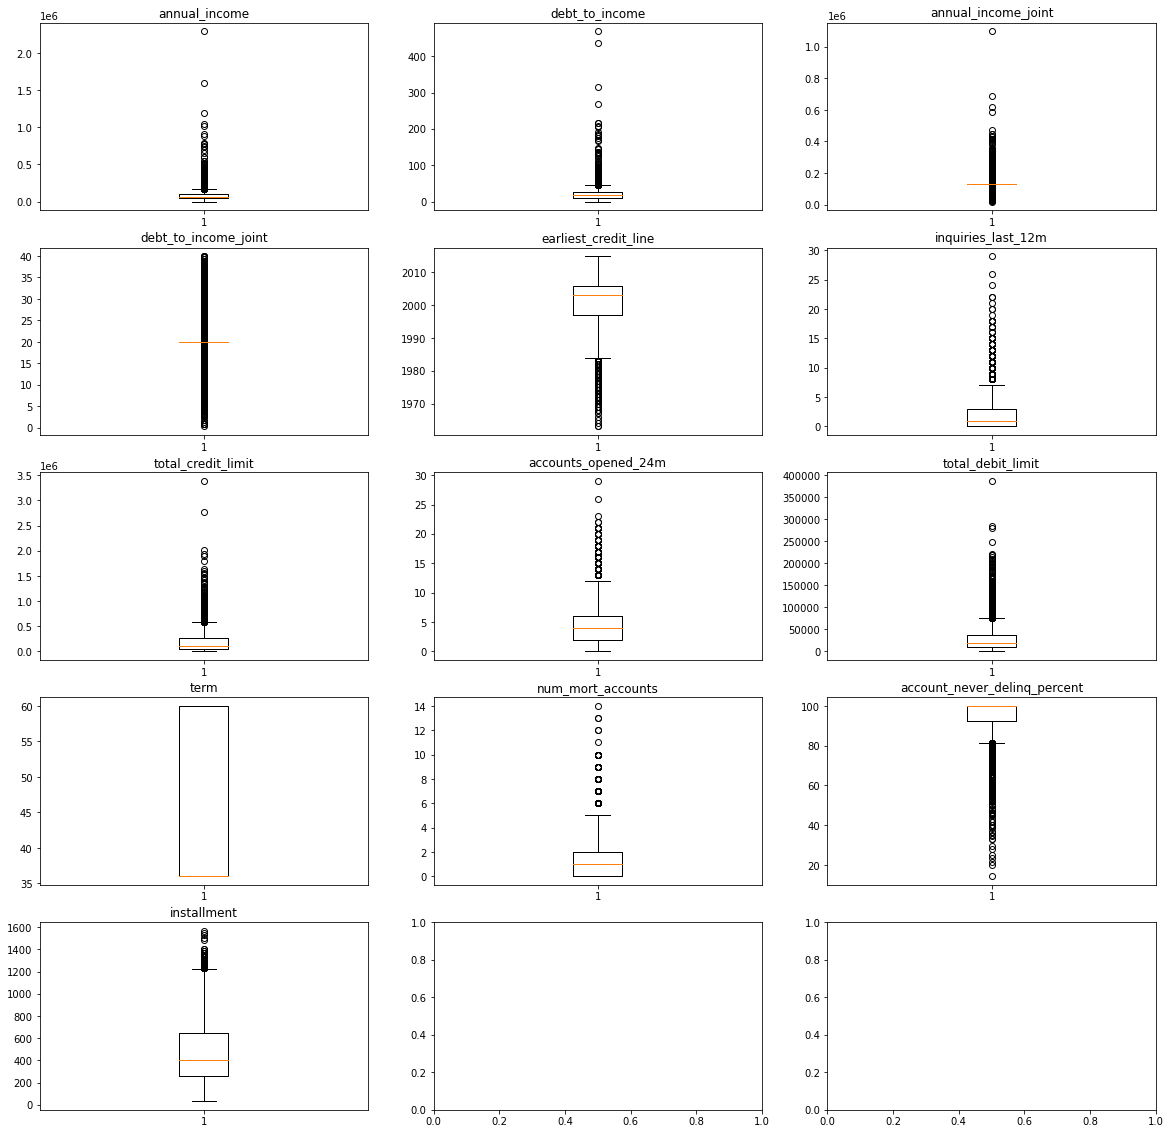

In [140]:
remove_outliers(features,'annual_income')
remove_outliers(features,'debt_to_income')
remove_outliers(features,'annual_income_joint')
remove_outliers(features,'debt_to_income_joint')


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6) ,(ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
fig.patch.set_facecolor('w')

ax1.boxplot(features['annual_income'])
ax2.boxplot(features['debt_to_income'])
ax3.boxplot(features['annual_income_joint'])
ax4.boxplot(features['debt_to_income_joint'])
ax5.boxplot(features['earliest_credit_line'])
ax6.boxplot(features['inquiries_last_12m'])
ax7.boxplot(features['total_credit_limit'])
ax8.boxplot(features['accounts_opened_24m'])
ax9.boxplot(features['total_debit_limit'])
ax10.boxplot(features['term'])
ax11.boxplot(features['num_mort_accounts'])
ax12.boxplot(features['account_never_delinq_percent'])
ax13.boxplot(features['installment'])




ax1.title.set_text('annual_income')
ax2.title.set_text('debt_to_income')
ax3.title.set_text('annual_income_joint')
ax4.title.set_text('debt_to_income_joint')
ax5.title.set_text('earliest_credit_line')
ax6.title.set_text('inquiries_last_12m')
ax7.title.set_text('total_credit_limit')
ax8.title.set_text('accounts_opened_24m')
ax9.title.set_text('total_debit_limit')
ax10.title.set_text('term')
ax11.title.set_text('num_mort_accounts')
ax12.title.set_text('account_never_delinq_percent')
ax13.title.set_text('installment')

In [141]:
features.to_csv('test1_pycaret.csv')